# Setup

In [57]:
import glob

import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import Image
%matplotlib inline

In [58]:
dir_path = "data/base microstructure"
img_num = 141
img_path = "{}/image_{}.png".format(dir_path, img_num)
gb_mask_path = "{}/gbmask_{}.png".format(dir_path, img_num)
lam_mask_path = "{}/lammask_{}.png".format(dir_path, img_num)
p1_mask_path = "{}/p1mask_{}.png".format(dir_path, img_num)
p2_mask_path = "{}/p2mask_{}.png".format(dir_path, img_num)
prec_mask_path = "{}/precmask_{}.png".format(dir_path, img_num)

In [59]:
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
gb_mask = cv2.imread(gb_mask_path, cv2.IMREAD_GRAYSCALE)
lam_mask = cv2.imread(lam_mask_path, cv2.IMREAD_GRAYSCALE)
p1_mask = cv2.imread(p1_mask_path, cv2.IMREAD_GRAYSCALE)
p2_mask = cv2.imread(p2_mask_path, cv2.IMREAD_GRAYSCALE)
prec_mask = cv2.imread(prec_mask_path, cv2.IMREAD_GRAYSCALE)

In [60]:
total_pixels = len(img.flatten())

def plot_all(images):
    columns = 3
    rows = 2
    
    fig=plt.figure(figsize=(12, 6))
    for i in range(1, columns*rows + 1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(images[i-1], cmap="gray")

    plt.show()
    
def save_image(image):
    cv2.imwrite("temp.png", image)

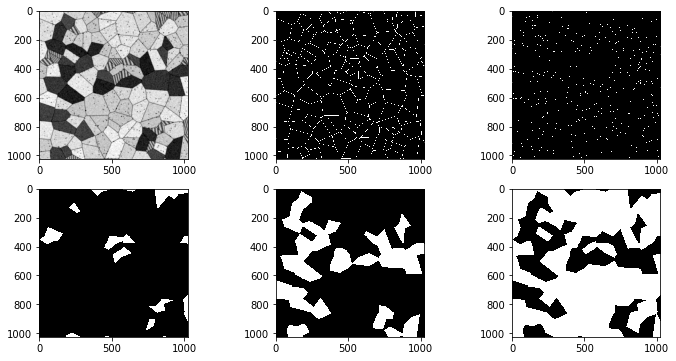

In [61]:
plot_all([img, gb_mask, prec_mask, lam_mask, p1_mask, p2_mask])

# Threshold

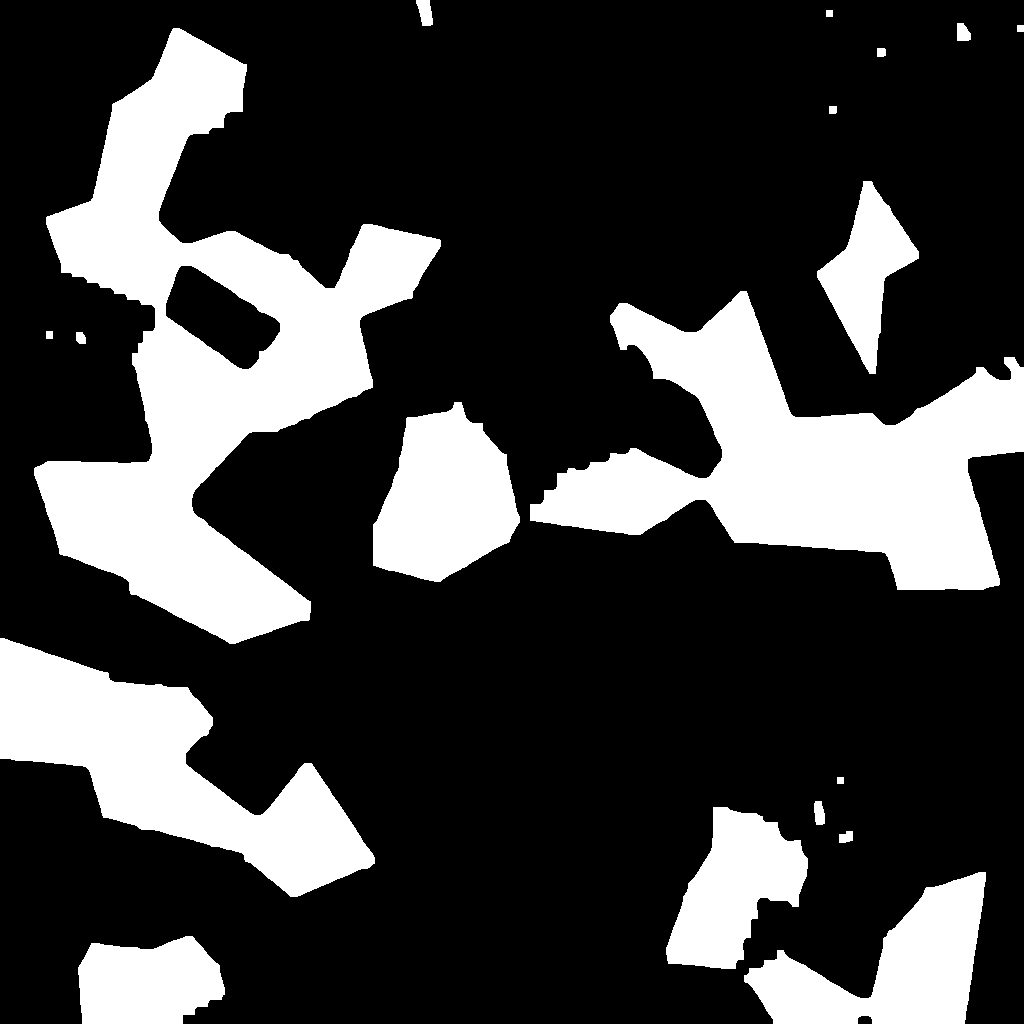

In [62]:
def threshold(image):
    _, thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    kernel = np.ones((3, 3), np.uint8)
    thresh = cv2.erode(thresh, kernel, iterations=6)
    thresh = cv2.dilate(thresh, kernel, iterations=3)

    return thresh

save_image(threshold(img))
Image("temp.png")

# Dark Mask

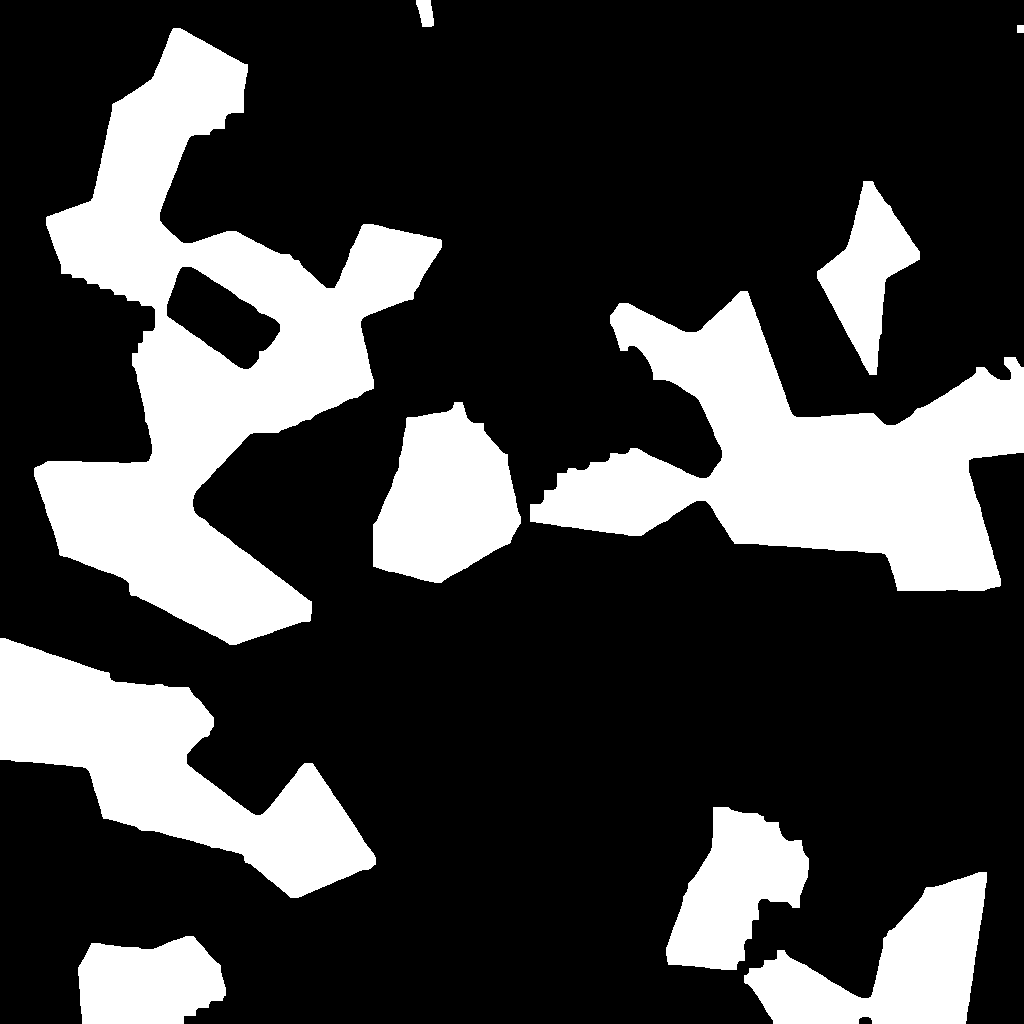

In [63]:
def fill1(image):
    not_image = cv2.bitwise_not(image)
    contours, _ = cv2.findContours(not_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    valid_contours = []
    for contour in contours:
        if cv2.contourArea(contour) < 2000:
            valid_contours.append(contour)

    out_image = image[:]
    out_image = cv2.fillPoly(out_image, pts=valid_contours, color=0)

    kernel = np.ones((2,2),np.uint8)
    out_image = cv2.dilate(out_image, kernel, iterations=1)

    return out_image

save_image(fill1(threshold(img)))
Image("temp.png")

# White Mask

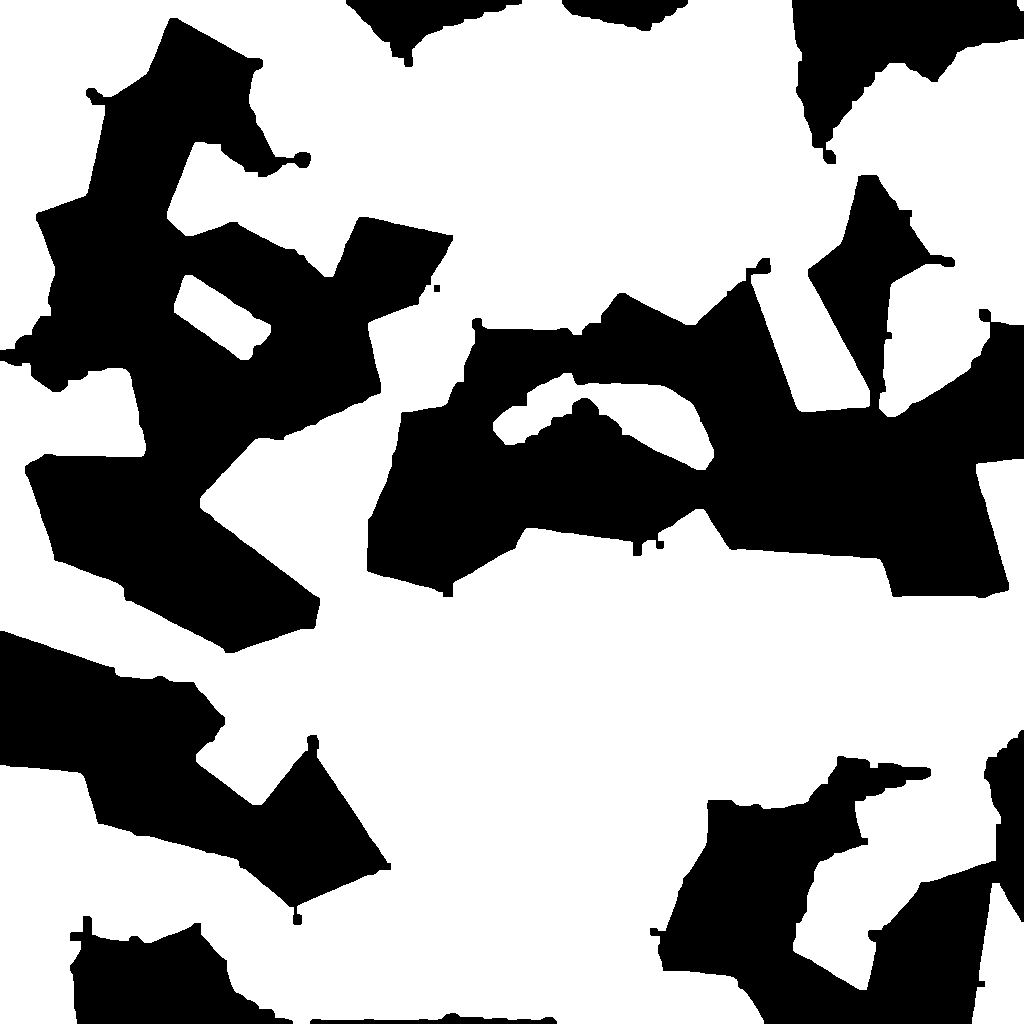

In [64]:
def fill2(image):
    not_image = cv2.bitwise_not(image)
    contours, _ = cv2.findContours(not_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    valid_contours = []
    for contour in contours:
        if cv2.contourArea(contour) < 1000:
            valid_contours.append(contour)

    out_image = image[:]
    out_image = cv2.fillPoly(out_image, pts=valid_contours, color=255)

    kernel = np.ones((2,2),np.uint8)
    out_image = cv2.dilate(out_image, kernel, iterations=1)

    return out_image

save_image(fill2(threshold(cv2.bitwise_not(img))))
Image("temp.png")

# Line Mask

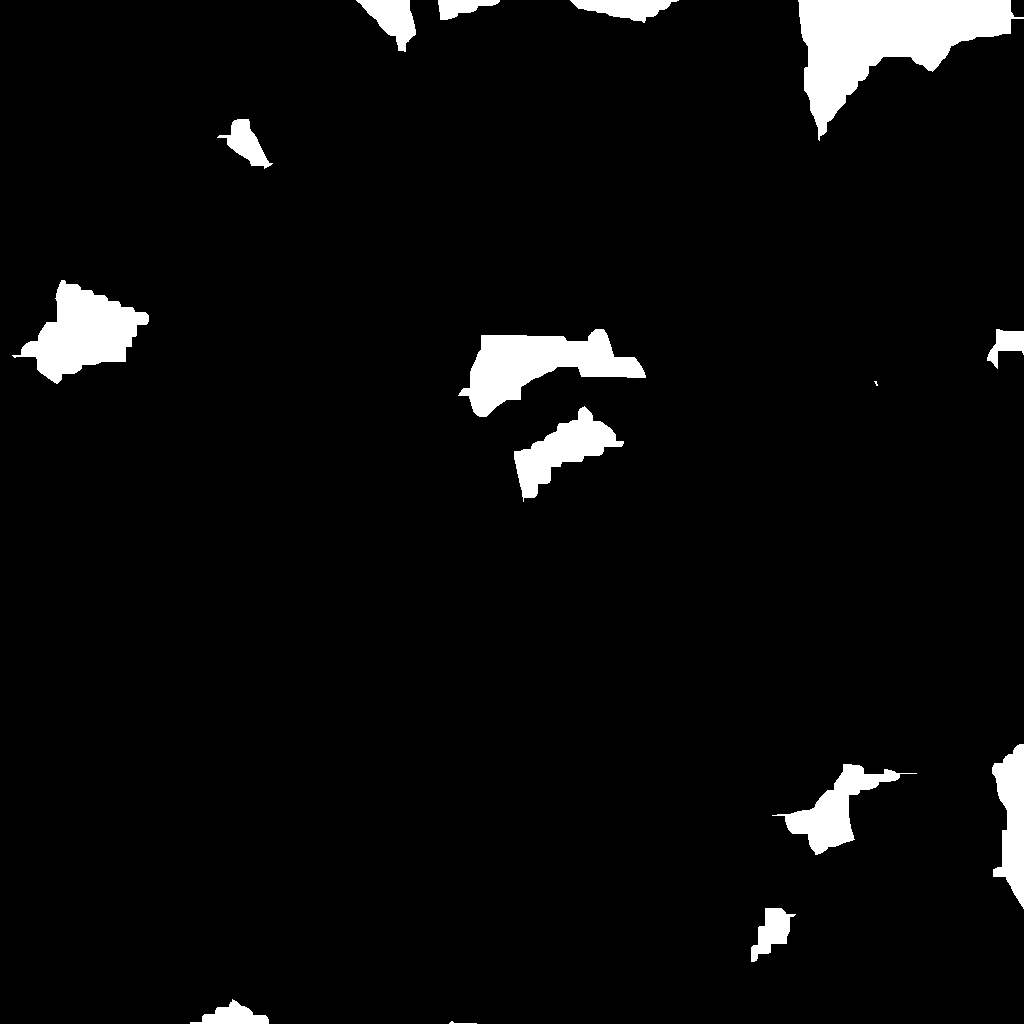

In [103]:
def get_dash_mask(image):
    dark = fill1(threshold(image))
    white = fill2(threshold(cv2.bitwise_not(image)))
    dash = np.zeros(image.shape, np.uint8)
    
    for i,(d,w) in enumerate(zip(dark, white)):
        for j,(a,b) in enumerate(zip(d,w)):
            if a or b:
                dash[i][j] = 255
    
    dash = cv2.bitwise_not(dash)
    
    kernel = np.ones((5,5),np.uint8)
    erosion = cv2.erode(dash ,kernel, iterations=3)
    
    return erosion
    
save_image(get_dash_mask(img))
Image("temp.png")

# All in One

In [137]:
def get_phase_masks(image):
    # dark mask
    _, thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    kernel = np.ones((3, 3), np.uint8)
    thresh = cv2.erode(thresh, kernel, iterations=6)
    thresh = cv2.dilate(thresh, kernel, iterations=3)
    
    inv_image = cv2.bitwise_not(thresh)
    contours, _ = cv2.findContours(inv_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    valid_contours = []
    for contour in contours:
        if cv2.contourArea(contour) < 2000:
            valid_contours.append(contour)

    dark_mask = thresh[:]
    dark_mask = cv2.fillPoly(dark_mask, pts=valid_contours, color=0)

    kernel = np.ones((2,2),np.uint8)
    dark_mask = cv2.dilate(dark_mask, kernel, iterations=1)

    # white mask
    inv_image = cv2.bitwise_not(image)
    _, thresh = cv2.threshold(inv_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    kernel = np.ones((3, 3), np.uint8)
    thresh = cv2.erode(thresh, kernel, iterations=6)
    thresh = cv2.dilate(thresh, kernel, iterations=3)
    
    inv_image = cv2.bitwise_not(thresh)
    contours, _ = cv2.findContours(inv_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    valid_contours = []
    for contour in contours:
        if cv2.contourArea(contour) < 1000:
            valid_contours.append(contour)

    white_mask = thresh[:]
    white_mask = cv2.fillPoly(white_mask, pts=valid_contours, color=255)

    kernel = np.ones((2,2),np.uint8)
    white_mask = cv2.dilate(white_mask, kernel, iterations=1)

    # line mask
    line_mask = np.zeros(image.shape, np.uint8)

    for i,(d,w) in enumerate(zip(dark_mask, white_mask)):
        for j,(a,b) in enumerate(zip(d,w)):
            if a or b:
                line_mask[i][j] = 255

    line_mask = cv2.bitwise_not(line_mask)

    kernel = np.ones((5,5),np.uint8)
    line_mask = cv2.erode(line_mask ,kernel, iterations=3)

    return dark_mask, white_mask, line_mask

In [138]:
im1, im2, im3 = get_phase_masks(img)

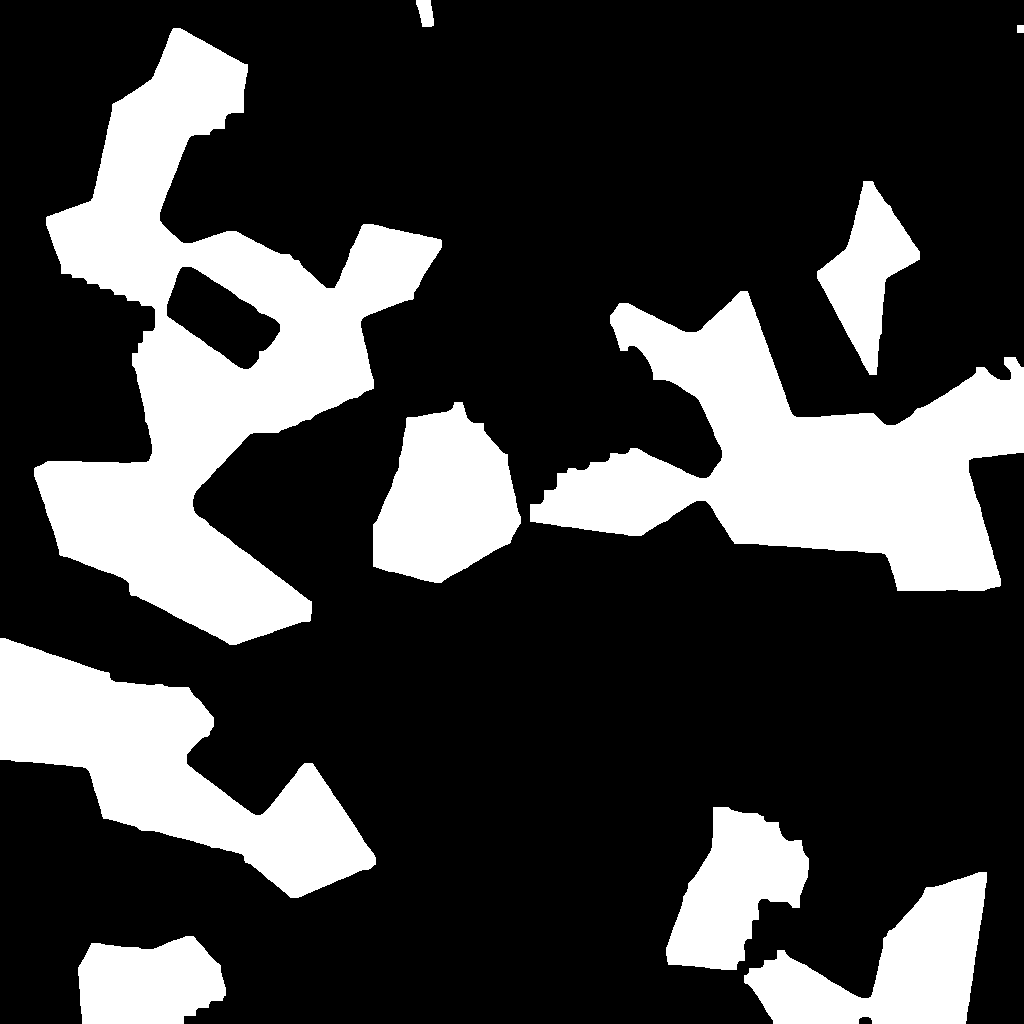

In [139]:
save_image(im1)
Image("temp.png")